<a href="https://colab.research.google.com/github/timaaos/rudalle_tests/blob/main/scaleupimage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [2]:
!nvidia-smi

Sat Jul  9 11:52:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install --upgrade rudalle==1.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 66 kB 5.1 MB/s 
     |████████████████████████████████| 60.3 MB 1.2 MB/s 
     |████████████████████████████████| 4.4 MB 55.9 MB/s 
     |████████████████████████████████| 1.7 MB 59.9 MB/s 
     |████████████████████████████████| 45 kB 3.8 MB/s 
     |████████████████████████████████| 79 kB 6.7 MB/s 
     |████████████████████████████████| 2.8 MB 49.9 MB/s 
     |████████████████████████████████| 58 kB 7.9 MB/s 
     |████████████████████████████████| 244 kB 19.1 MB/s 
     |████████████████████████████████| 585 kB 25.5 MB/s 
     |████████████████████████████████| 117 kB 21.4 MB/s 
     |████████████████████████████████| 596 kB 65.2 MB/s 
     |████████████████████████████████| 140 kB 63.4 MB/s 
     |████████████████████████████████| 419 kB 63.2 MB/s 
     |████████████████████████████████| 1

In [4]:
#@title Текст заголовка по умолчанию
# -*- coding: utf-8 -*-
import os

import torch
from huggingface_hub import hf_hub_url, cached_download
from rudalle.dalle import MODELS
from rudalle.dalle.model import DalleModel
from rudalle.dalle.fp16 import FP16Module


MODELS.update({
    'Surrealist_XL': dict(
        hf_version='v3',
        description='Surrealist is 1.3 billion params model from the family GPT3-like, '
                    'that was trained on surrealism and Russian.',
        model_params=dict(
            num_layers=24,
            hidden_size=2048,
            num_attention_heads=16,
            embedding_dropout_prob=0.1,
            output_dropout_prob=0.1,
            attention_dropout_prob=0.1,
            image_tokens_per_dim=32,
            text_seq_length=128,
            cogview_sandwich_layernorm=True,
            cogview_pb_relax=True,
            vocab_size=16384 + 128,
            image_vocab_size=8192,
        ),
        repo_id='shonenkov-AI/rudalle-xl-surrealist',
        filename='pytorch_model.bin',
        authors='shonenkovAI',
        full_description='',
    )
})


def get_rudalle_model(name, pretrained=True, fp16=False, device='cpu', cache_dir='/tmp/rudalle', **model_kwargs):
    assert name in MODELS

    if fp16 and device == 'cpu':
        print('Warning! Using both fp16 and cpu doesnt support. You can use cuda device or turn off fp16.')

    config = MODELS[name].copy()
    config['model_params'].update(model_kwargs)
    model = DalleModel(device=device, **config['model_params'])
    if pretrained:
        cache_dir = os.path.join(cache_dir, name)
        config_file_url = hf_hub_url(repo_id=config['repo_id'], filename=config['filename'])
        cached_download(config_file_url, cache_dir=cache_dir, force_filename=config['filename'])
        checkpoint = torch.load(os.path.join(cache_dir, config['filename']), map_location='cpu')
        model.load_state_dict(checkpoint)
    if fp16:
        model = FP16Module(model)
    model.eval()
    model = model.to(device)
    if config['description'] and pretrained:
        print(config['description'])
    return model
from rudalle.pipelines import generate_images, show, super_resolution
from rudalle.image_prompts import ImagePrompts
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan
from rudalle.utils import seed_everything
device = 'cuda'
dalle = get_rudalle_model('Surrealist_XL', fp16=True, device=device)
realesrgan = get_realesrgan('x4', device=device)
tokenizer = get_tokenizer()
vae = get_vae().to(device)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:563: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


Downloading:   0%|          | 0.00/2.62G [00:00<?, ?B/s]

Surrealist is 1.3 billion params model from the family GPT3-like, that was trained on surrealism and Russian.


Downloading:   0%|          | 0.00/67.0M [00:00<?, ?B/s]

x4 --> ready


Downloading:   0%|          | 0.00/224k [00:00<?, ?B/s]

tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.


Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

vae --> ready


# Scaleout

configure the generation (you need to run settings script when you done with config) and run script below

In [8]:
import math
pr = "\u043F\u043E\u043B\u044F\u043D\u0430 \u0441 \u0440\u0430\u0437\u043D\u043E\u0446\u0432\u0435\u0442\u043D\u044B\u043C\u0438 \u0446\u0432\u0435\u0442\u0430\u043C\u0438" #@param {type: "string"}
seed =  414212#@param {type: "integer"}
qual = 1024 #@param {type:"slider", min:256, max:2048, step:64}
scaleout_amount = 8#@param {type:"integer"}
zoomout_pixels = 50 
borders_dirsize = 26
print("borders_dirsize calculated:"+str(borders_dirsize))
rotate_deg = 0 

borders_dirsize calculated:26


  0%|          | 0/1024 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rudalle/dalle/model.py:85: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=self.device) // self.image_tokens_per_dim


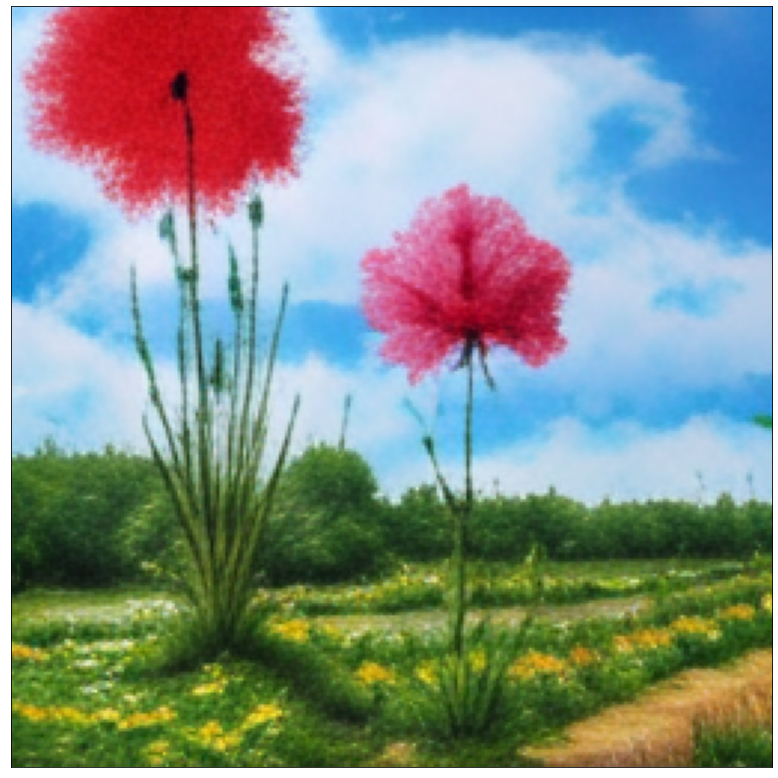

Generating поляна с разноцветными цветами with quality 1024, seed 414212


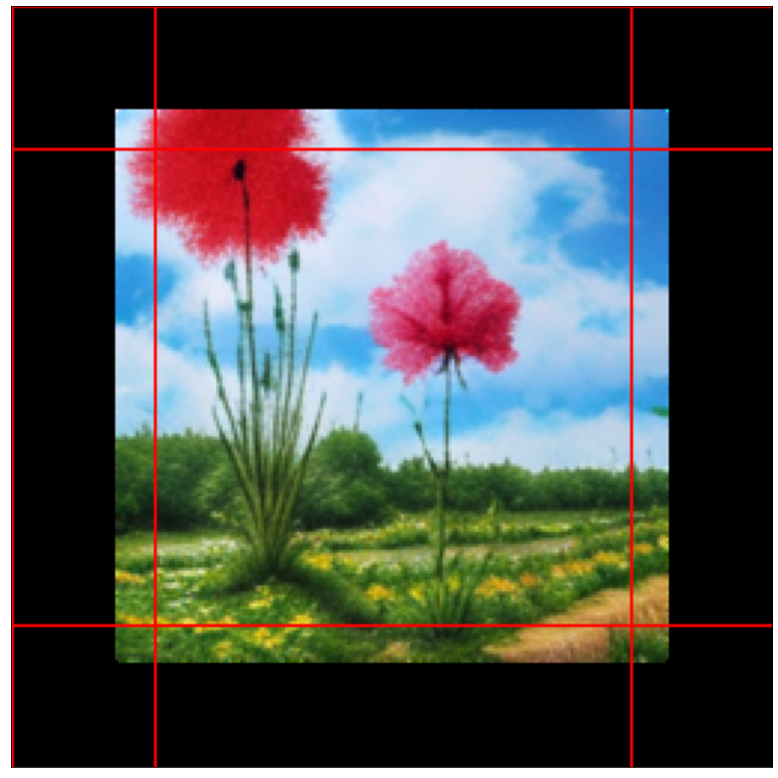

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

Generating поляна с разноцветными цветами with quality 1024, seed 414212


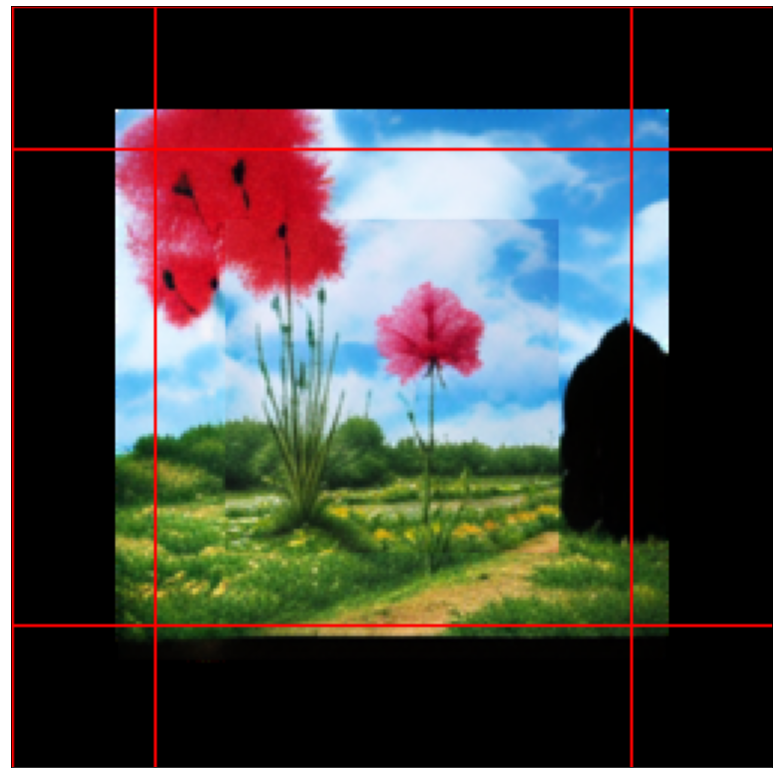

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

Generating поляна с разноцветными цветами with quality 1024, seed 414212


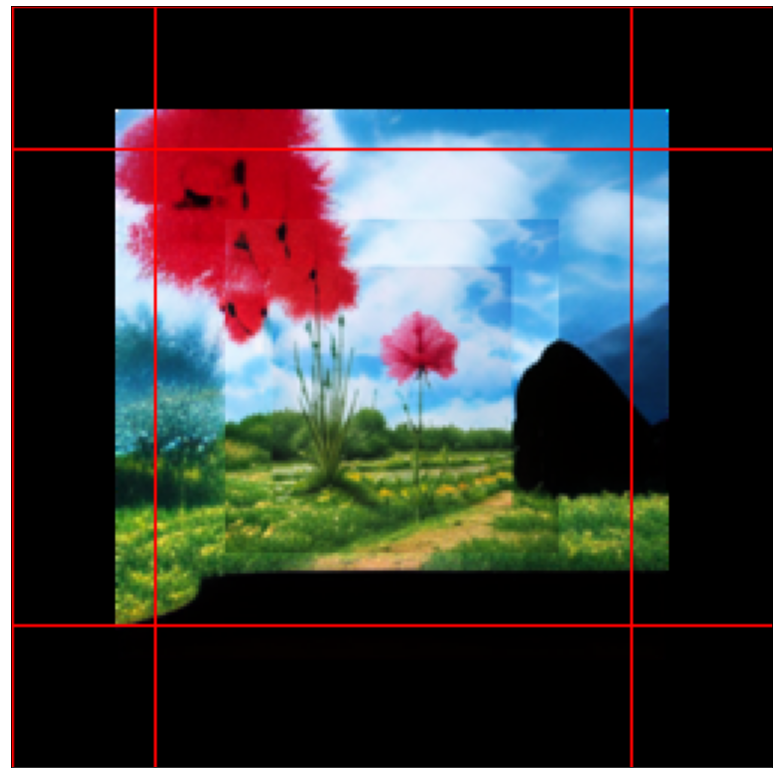

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

Generating поляна с разноцветными цветами with quality 1024, seed 414212


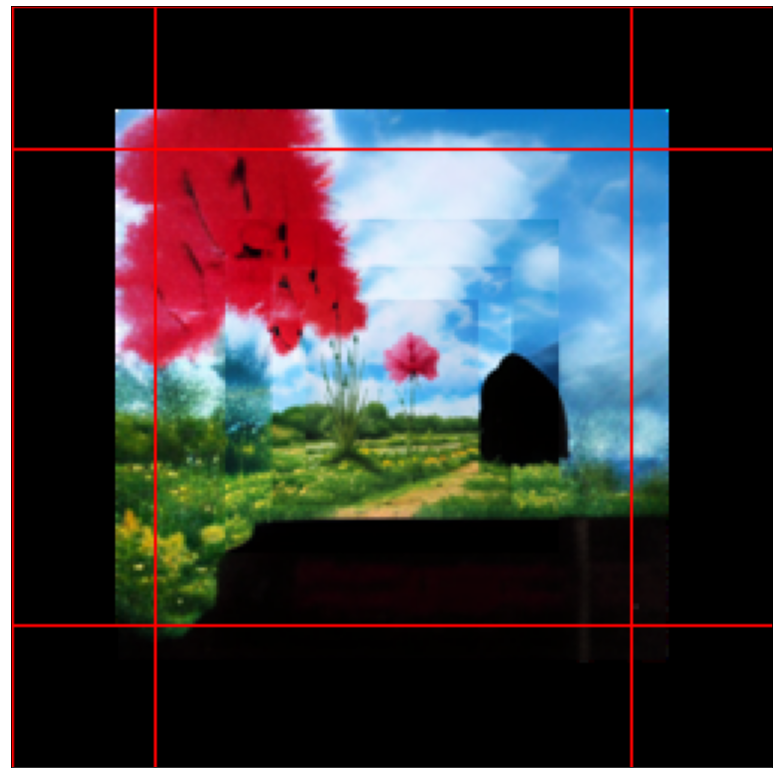

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

Generating поляна с разноцветными цветами with quality 1024, seed 414212


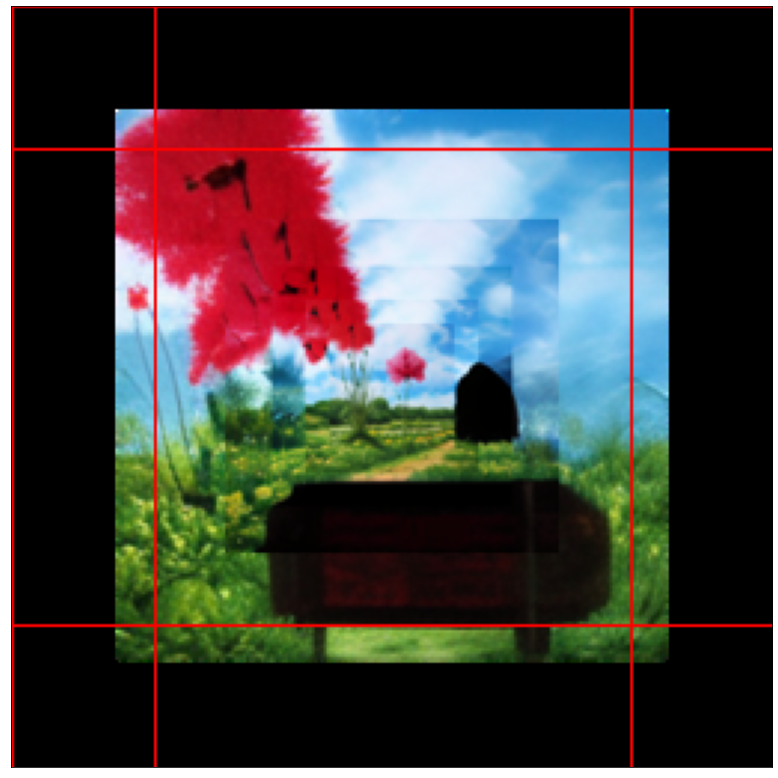

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

Generating поляна с разноцветными цветами with quality 1024, seed 414212


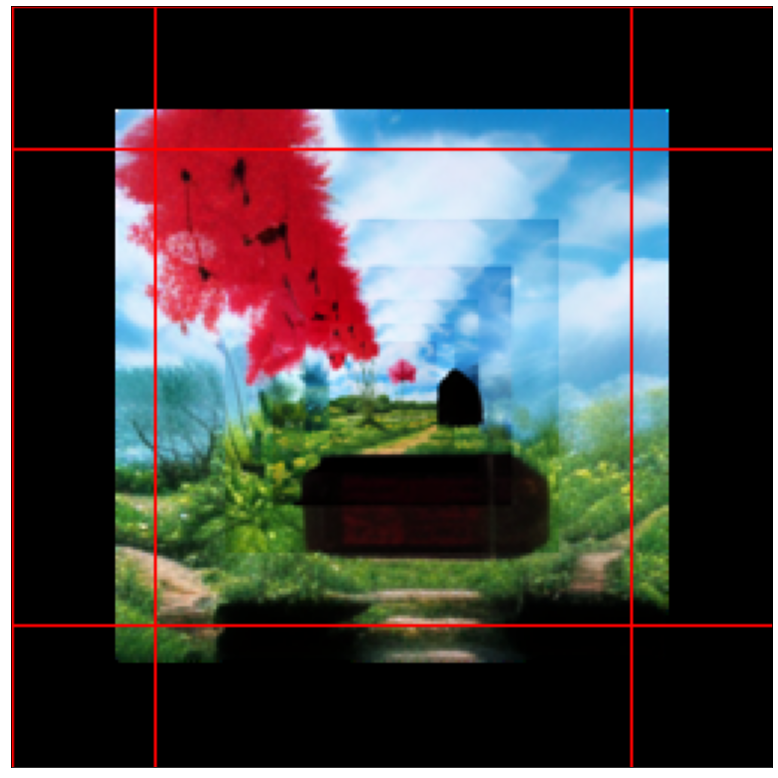

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

Generating поляна с разноцветными цветами with quality 1024, seed 414212


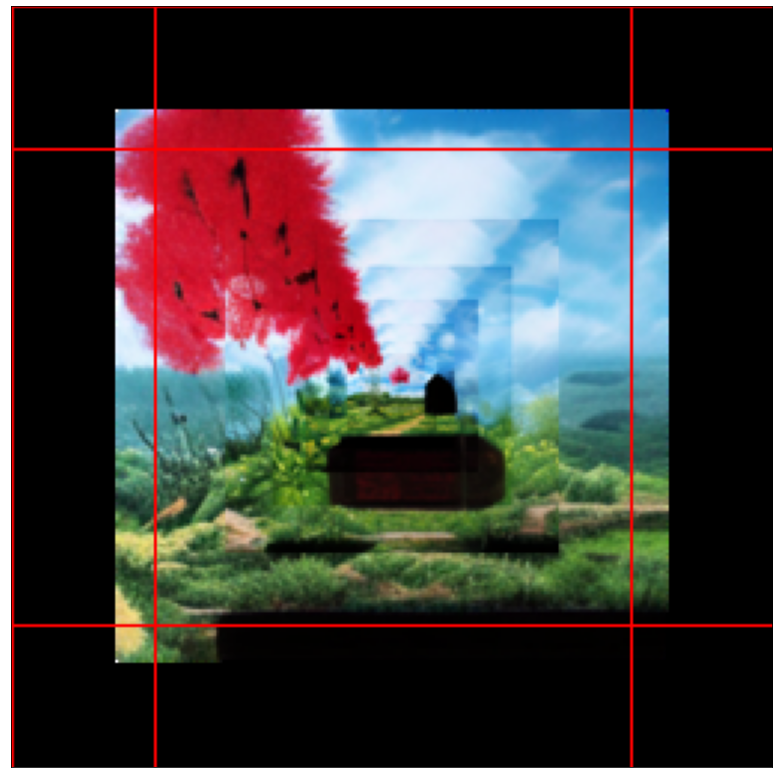

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

Generating поляна с разноцветными цветами with quality 1024, seed 414212


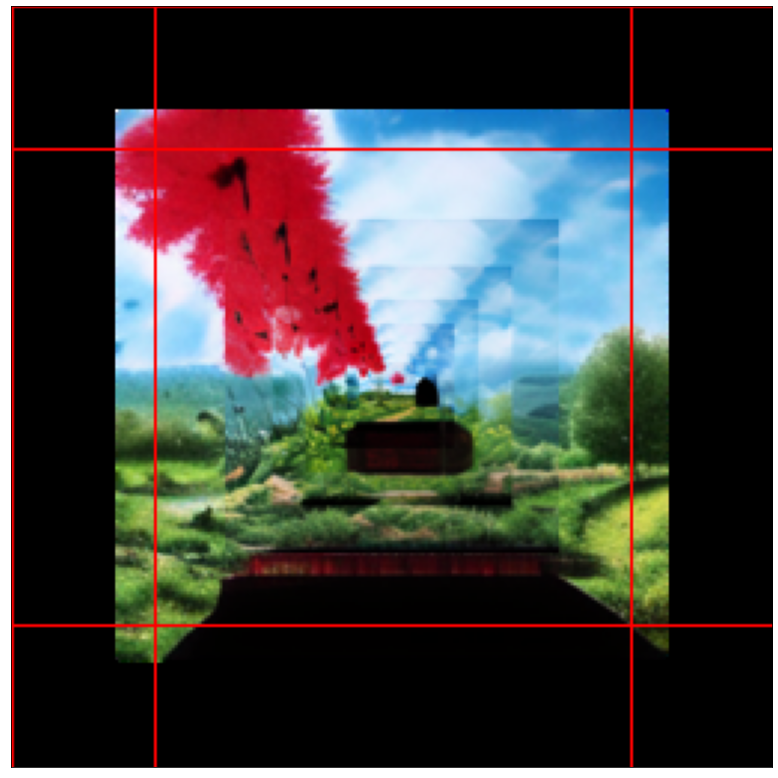

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
from collections import defaultdict
from PIL import Image, ImageDraw
import os
import torch
import shutil
import math
from google.colab import files
if os.path.isdir("./out") == False:
  os.mkdir("./out")
else:
  shutil.rmtree("./out")
  os.mkdir("./out")
#qual += 256
oldseed = seed
images = []

seed_everything(seed)
pil_images = []
scores = []
for top_k, top_p, images_num in [
    (qual, 0.995, 1),
]:
    _pil_images, _scores = generate_images(pr, tokenizer, dalle, vae, top_k=top_k, images_num=images_num, bs=8, top_p=top_p)
    pil_images += _pil_images
    scores += _scores
pil_images[0].save("result.png")
pil_images[0].save("./out/0.png")
show(pil_images,1)
images.append(pil_images[0])
allBorders = [{'up': 0, 'left': 0, 'right': 0, 'down': borders_dirsize},{'up': borders_dirsize, 'left': 0, 'right': 0, 'down': 0},{'up': 0, 'left': borders_dirsize, 'right': 0, 'down': 0},{'up': 0, 'left': 0, 'right': borders_dirsize, 'down': 0}]
for i in range(scaleout_amount):
  seed = seed+1
  # Formatting "result.png"
  name = "result.png"
  image = Image.open(name)
  imb = Image.new("RGBA",(image.size[0]+zoomout_pixels*2,image.size[1]+zoomout_pixels*2),(255,255,255,0))
  imb.paste(image,(zoomout_pixels,zoomout_pixels))
  imb.save("toPrompt.png","PNG")

  print(f"Generating {pr} with quality {qual}, seed {seed}")
  toPrompt = Image.open("toPrompt.png").resize((256, 256)).convert("RGBA")
  oToPrompt = toPrompt
  oToPrompt = oToPrompt.crop((zoomout_pixels+10,zoomout_pixels+10,oToPrompt.size[0]-zoomout_pixels+10,oToPrompt.size[1]-zoomout_pixels+10))
  topP = 0.995
  copy = toPrompt.copy()
  copyD  = ImageDraw.Draw(copy)
  for b in allBorders:
    copyD.rectangle((b["left"]*8,b['up']*8,copy.size[0]-b['right']*8,copy.size[1]-b['down']*8),outline="red")
  show([copy],1)
  all_images = []


  for borders in allBorders:
    pt_items = {
        'topr': {
            'prompt': ImagePrompts(
                toPrompt, 
                borders,
                vae, 
                torch.device('cuda')
            ),
            'texts': [
                pr
            ]
        }
    }
    all_images = defaultdict(list)

    for name, item in pt_items.items():
        seed_everything(seed)
        for text in item['texts']:
            pil_images = []
            for top_k, top_p, images_num in [
                (qual, topP, 1),
            ]:
                _pil_images, _ = generate_images(
                    text,
                    tokenizer,
                    dalle,
                    vae,
                    top_k=top_k,
                    images_num=images_num,
                    image_prompts=item['prompt'],
                    top_p=top_p,
                    use_cache=True
                )
                pil_images += _pil_images
            all_images[name] += pil_images
    all_images["topr"][0].save("result.png","PNG")
    toPrompt = Image.open("result.png").resize((256, 256)).convert("RGBA")

  #Saving
  all_images["topr"][0].paste(oToPrompt,(zoomout_pixels,zoomout_pixels))
  all_images["topr"][0].save("result.png","PNG")
  all_images["topr"][0].save("./out/"+str(i+1)+".png","PNG")
  s = super_resolution(all_images["topr"],realesrgan)
  s[0].save("./out/"+str(i+1)+"Up.png","PNG")
  images.append(all_images["topr"][0])
images[0].save('./out/animated.gif',
               save_all = True, append_images = images[1:], 
               optimize = False, duration = math.floor(1000/len(images)))
shutil.make_archive("ScaleupOut", 'zip', "./out/")
files.download("ScaleupOut.zip")
shutil.rmtree("./out")
seed = oldseed

# Old code

Formatting file result.png for rudalle
Generating тигр with quality 1024, seed 12421


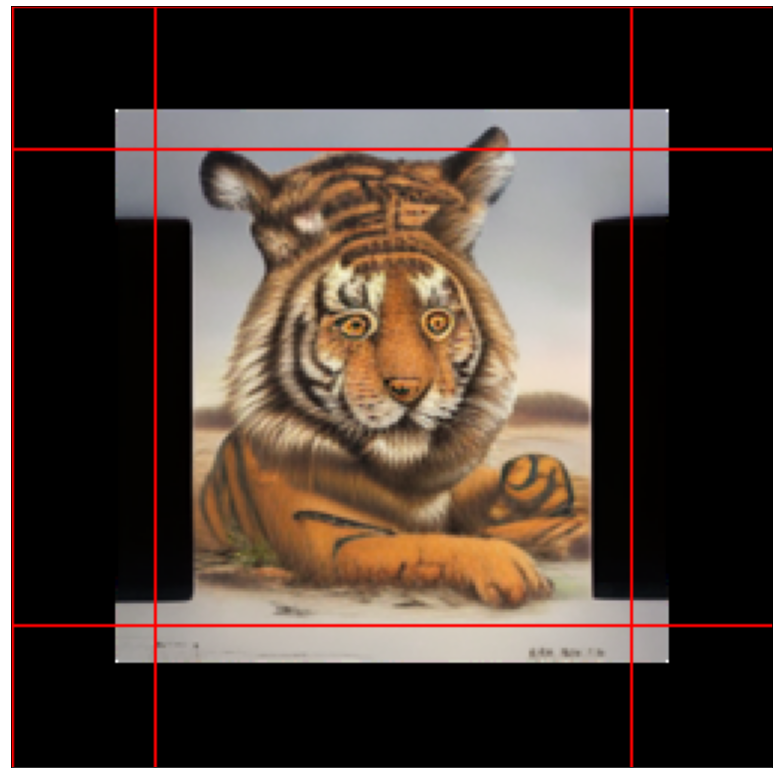

  0%|          | 0/1024 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rudalle/dalle/model.py:85: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=self.device) // self.image_tokens_per_dim


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

In [ ]:
from collections import defaultdict
from PIL import Image, ImageDraw
import os
import torch
#qual += 256
allBorders = [{'up': 0, 'left': 0, 'right': 0, 'down': borders_dirsize},{'up': borders_dirsize, 'left': 0, 'right': 0, 'down': 0},{'up': 0, 'left': borders_dirsize, 'right': 0, 'down': 0},{'up': 0, 'left': 0, 'right': borders_dirsize, 'down': 0}]
for i in range(1):
  # Formatting "result.png"
  name = "result.png"
  image = Image.open(name)
  imb = Image.new("RGBA",(image.size[0]+zoomout_pixels*2,image.size[1]+zoomout_pixels*2),(255,255,255,0))
  imb.paste(image,(zoomout_pixels,zoomout_pixels))
  imb.save("toPrompt.png","PNG")

  print(f"Generating {pr} with quality {qual}, seed {seed}")
  toPrompt = Image.open("toPrompt.png").resize((256, 256)).convert("RGBA")
  oToPrompt = toPrompt
  oToPrompt = oToPrompt.crop((75,75,oToPrompt.size[0]-75,oToPrompt.size[1]-75))
  topP = 0.995
  copy = toPrompt.copy()
  copyD  = ImageDraw.Draw(copy)
  for b in allBorders:
    copyD.rectangle((b["left"]*8,b['up']*8,copy.size[0]-b['right']*8,copy.size[1]-b['down']*8),outline="red")
  show([copy],1)
  all_images = []


  for borders in allBorders:
    pt_items = {
        'topr': {
            'prompt': ImagePrompts(
                toPrompt, 
                borders,
                vae, 
                torch.device('cuda')
            ),
            'texts': [
                pr
            ]
        }
    }
    all_images = defaultdict(list)

    for name, item in pt_items.items():
        seed_everything(seed)
        for text in item['texts']:
            pil_images = []
            for top_k, top_p, images_num in [
                (qual, topP, 1),
            ]:
                _pil_images, _ = generate_images(
                    text,
                    tokenizer,
                    dalle,
                    vae,
                    top_k=top_k,
                    images_num=images_num,
                    image_prompts=item['prompt'],
                    top_p=top_p,
                    use_cache=False
                )
                pil_images += _pil_images
            all_images[name] += pil_images
    all_images["topr"][0].save("result.png","PNG")
    toPrompt = Image.open("result.png").resize((256, 256)).convert("RGBA")

  #Saving
  all_images["topr"][0].paste(oToPrompt,(75,75))
  all_images["topr"][0].save("result.png","PNG")
  s = super_resolution(all_images["topr"],realesrgan)
  s[0].save("resultU.png","PNG")

  #pt_items2 = {
  #    'topr': {
  #        'prompt': ImagePrompts(
  #            toPrompt, 
  #            allBorders[1],
  #            vae, 
  #            torch.device('cuda')
  #        ),
  #        'texts': [
  #            pr
  #        ]
  #    }
  #}
  #toPrompt = Image.open("result.png").resize((256, 256)).convert("RGBA")
  #all_images = defaultdict(list)
  #
  #for name, item in pt_items2.items():
  #    seed_everything(seed)
  #    for text in item['texts']:
  #        pil_images = []
  #        for top_k, top_p, images_num in [
  #            (qual, topP, 1),
  #        ]:
  #            _pil_images, _ = generate_images(
  #                text,
  #                tokenizer,
  #                dalle,
  #                vae,
  #                top_k=top_k,
  #                images_num=images_num,
  #                image_prompts=item['prompt'],
  #                top_p=top_p,
  #                use_cache=False
  #            )
  #            pil_images += _pil_images
  #        all_images[name] += pil_images
  #all_images["topr"][0].save("result.png","PNG")
  #toPrompt = Image.open("result.png").resize((256, 256)).convert("RGBA")
  #pt_items3 = {
  #    'topr': {
  #        'prompt': ImagePrompts(
  #            toPrompt, 
  #            allBorders[2],
  #            vae, 
  #            torch.device('cuda')
  #        ),
  #        'texts': [
  #            pr
  #        ]
  #    }
  #}
  #all_images = defaultdict(list)
  #
  #for name, item in pt_items3.items():
  #    seed_everything(seed)
  #    for text in item['texts']:
  #        pil_images = []
  #        for top_k, top_p, images_num in [
  #            (qual, topP, 1),
  #        ]:
  #            _pil_images, _ = generate_images(
  #                text,
  #                tokenizer,
  #                dalle,
  #                vae,
  #                top_k=top_k,
  #                images_num=images_num,
  #                image_prompts=item['prompt'],
  #                top_p=top_p,
  #                use_cache=False
  #            )
  #            pil_images += _pil_images
  #        all_images[name] += pil_images
  #all_images["topr"][0].save("result.png","PNG")
  #toPrompt = Image.open("result.png").resize((256, 256)).convert("RGBA")
  #pt_items4 = {
  #    'topr': {
  #        'prompt': ImagePrompts(
  #            toPrompt, 
  #            allBorders[3],
  #            vae, 
  #            torch.device('cuda')
  #        ),
  #        'texts': [
  #            pr
  #        ]
  #    }
  #}
  #all_images = defaultdict(list)
  #
  #for name, item in pt_items4.items():
  #    seed_everything(seed)
  #    for text in item['texts']:
  #        pil_images = []
  #        for top_k, top_p, images_num in [
  #            (qual, topP, 1),
  #        ]:
  #            _pil_images, _ = generate_images(
  #                text,
  #                tokenizer,
  #                dalle,
  #                vae,
  #                top_k=top_k,
  #                images_num=images_num,
  #                image_prompts=item['prompt'],
  #                top_p=top_p,
  #                use_cache=False
  #            )
  #            pil_images += _pil_images
  #        all_images[name] += pil_images

In [ ]:
show(all_images['topr'], 1)
show(s, 1)

# Generate first image


  0%|          | 0/1024 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rudalle/dalle/model.py:85: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=self.device) // self.image_tokens_per_dim


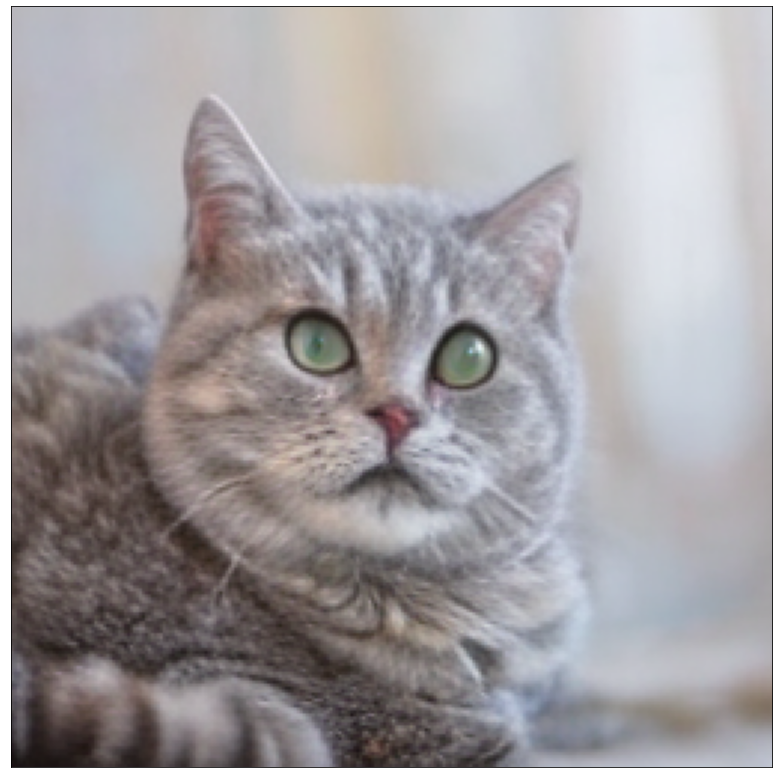

In [ ]:
seed_everything(seed)
pil_images = []
scores = []
for top_k, top_p, images_num in [
    (qual, 0.995, 1),
]:
    _pil_images, _scores = generate_images(pr, tokenizer, dalle, vae, top_k=top_k, images_num=images_num, bs=8, top_p=top_p)
    pil_images += _pil_images
    scores += _scores
pil_images[0].save("result.png")
show(pil_images,1)

In [ ]:
from google.colab import files
from PIL import Image
import os

mode = 1 # mode: 0 - upload file, 1 - use result.png

name = ""
if mode == 0:
  uploaded = files.upload()
  name = next(iter(uploaded))
elif mode == 1:
  name = "result.png"
print(f"Formatting file {name} for rudalle")
image = Image.open(name)
imb = Image.new("RGBA",(image.size[0]+zoomout_pixels*2,image.size[1]+zoomout_pixels*2),(255,255,255,0))
imb.paste(image,(zoomout_pixels,zoomout_pixels))
imb.save("toPrompt.png","PNG")
os.remove(name)


Formatting file result.png for rudalle
